### Import libraries and Data 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from concurrent.futures import ThreadPoolExecutor
from scipy.ndimage import distance_transform_edt
import cv2
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision.models import resnet34
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm


In [6]:
image_data = np.load('image256.npy')
mask_data=np.load('mask256.npy')
image_test=np.load('test256.npy')

### Data structure

#### Split data

In [7]:
data_image_train, data_image_val, data_mask_train, data_mask_val = train_test_split(image_data, mask_data, test_size=0.2)

#### Features functions

In [8]:
def corners_density_map_direct(
    gray, gaussian_size=21, sigma=3, max_corners=100000, quality_level=0.3, min_distance=2
):
    """
    Génère une carte de densité gaussienne pour chaque coin détecté, sans flouter l'image.

    Args:
        gray (np.ndarray): Image en niveaux de gris (type np.uint8 ou np.float32).
        gaussian_size (int): Taille du noyau gaussien (doit être impair).
        sigma (float): Écart type de la gaussienne.
        max_corners (int): Nombre maximum de coins à détecter.
        quality_level (float): Qualité minimale des coins à retenir (valeur entre 0 et 1).
        min_distance (float): Distance minimale entre deux coins détectés.

    Returns:
        np.ndarray: Carte de densité gaussienne avec les coins détectés.
    """
    # Vérifiez que l'image est bien en niveaux de gris
    if len(gray.shape) != 2:
        raise ValueError("L'image d'entrée doit être en niveaux de gris (2D).")
    
    # Vérifier et ajuster la taille du noyau gaussien
    if gaussian_size % 2 == 0:
        gaussian_size += 1

    # Convertir en type attendu par OpenCV si nécessaire
    if gray.dtype != np.uint8 and gray.dtype != np.float32:
        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Détecter les coins avec Shi-Tomasi
    corners = cv2.goodFeaturesToTrack(gray, maxCorners=max_corners, qualityLevel=quality_level, minDistance=min_distance)

    # Si aucun coin n'est détecté, retourner un masque noir
    if corners is None:
        return np.zeros_like(gray, dtype=np.float32)

    # Convertir les coordonnées en entiers
    corners = np.int0(corners)

    # Créer une image pour accumuler les gaussiennes
    density_map = np.zeros_like(gray, dtype=np.float32)

    # Préparer une gaussienne 2D
    center = gaussian_size // 2
    x = np.arange(0, gaussian_size) - center
    y = np.arange(0, gaussian_size) - center
    xv, yv = np.meshgrid(x, y)
    gaussian_kernel = np.exp(-(xv**2 + yv**2) / (2 * sigma**2))
    gaussian_kernel /= gaussian_kernel.sum()

    # Ajouter la gaussienne pour chaque coin détecté
    for corner in corners:
        x, y = corner.ravel()

        # Déterminer les limites de placement de la gaussienne
        x_min = max(0, x - center)
        x_max = min(density_map.shape[1], x + center + 1)
        y_min = max(0, y - center)
        y_max = min(density_map.shape[0], y + center + 1)

        # Déterminer les indices correspondants dans la gaussienne
        gauss_x_min = max(0, center - x)
        gauss_x_max = gaussian_size - max(0, (x + center + 1) - density_map.shape[1])
        gauss_y_min = max(0, center - y)
        gauss_y_max = gaussian_size - max(0, (y + center + 1) - density_map.shape[0])

        # Ajouter la gaussienne au masque
        density_map[y_min:y_max, x_min:x_max] += gaussian_kernel[gauss_y_min:gauss_y_max, gauss_x_min:gauss_x_max]

    # Normaliser la carte de densité pour rester dans l'intervalle [0, 255]
    density_map = cv2.normalize(density_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return density_map/255

def generate_tsdf_map(mask, truncation=10):
    """
    Génère la carte TSDF pour un masque binaire.
    Args:
        mask (np.ndarray): Masque binaire (H, W).
        truncation (float): Valeur maximale de troncature (\tau).
    Returns:
        np.ndarray: Carte TSDF tronquée.
    """
    inside_dist = -distance_transform_edt(mask)
    outside_dist = distance_transform_edt(1 - mask)
    tsdf = np.where(mask, 
                    1 + np.minimum(-inside_dist, truncation) / truncation,
                    -1 - np.minimum(outside_dist, truncation) / truncation)
    return (tsdf+2)/4

#### Data préparation

In [9]:
class BuildingDataset(Dataset):
    def __init__(self, image_data, mask_data):
        self.images = image_data
        self.masks = mask_data

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Charger l'image et le masque
        image = self.images[idx]
        mask = self.masks[idx]


        # Convertir en tenseurs PyTorch
        image_tensor = torch.tensor(image, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32)
        tsdf_map = torch.tensor(generate_tsdf_map(mask), dtype=torch.float32)
        corner_map = torch.tensor(corners_density_map_direct(mask), dtype=torch.float32)


        return (
            image_tensor,
            mask_tensor,
            tsdf_map,
            corner_map,
        )

In [10]:
train_dataset = BuildingDataset(data_image_train, data_mask_train)
val_dataset = BuildingDataset(data_image_val,data_mask_val)

trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=16, shuffle=False)


(-0.5, 255.5, 255.5, -0.5)

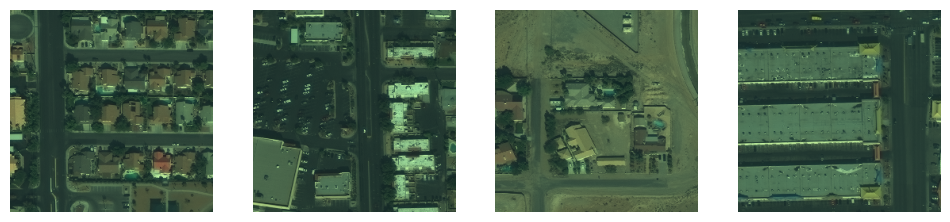

In [11]:
plt.figure(figsize=(12,12))

plt.subplot(1,4,1)
plt.imshow(image_data[624])
plt.axis("off")
plt.subplot(1,4,2)
plt.imshow(image_data[1364])
plt.axis("off")
plt.subplot(1,4,3)
plt.imshow(image_data[3491])
plt.axis("off")
plt.subplot(1,4,4)
plt.imshow(image_data[2294])
plt.axis("off")

<ipython-input-8-03b6efd5578a>:38: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


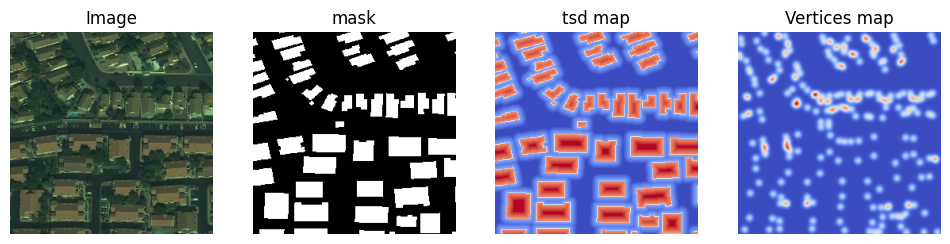

In [12]:
image, mask, tsdf_map, corner_map = train_dataset[120]

plt.figure(figsize=(12,12))

plt.subplot(1,4,1)

plt.imshow(image.numpy())


plt.title("Image")
plt.axis("off")


plt.subplot(1,4,2)

plt.imshow(mask.numpy(), cmap='gray')
plt.title("mask")
plt.axis("off")

plt.subplot(1,4,3)

plt.imshow(tsdf_map.numpy(),cmap='coolwarm')
plt.title("tsd map")
plt.axis("off")


plt.subplot(1,4,4)

plt.imshow(corner_map.numpy(),cmap='coolwarm')
plt.title("Vertices map")
plt.axis("off")

plt.show()


### Implementing Model 

#### Model 

In [8]:
class Unet_buil_seg(nn.Module):
    def __init__(self, in_channels=3, out_channels_seg=1):
        super(Unet_buil_seg, self).__init__()
        
        base_model = resnet34(pretrained=True)
        self.encoder_layers = list(base_model.children())
        self.encoder1 = nn.Sequential(*self.encoder_layers[:3])  
        self.encoder2 = nn.Sequential(*self.encoder_layers[3:5]) 
        self.encoder3 = self.encoder_layers[5]  
        self.encoder4 = self.encoder_layers[6] 
        self.encoder5 = self.encoder_layers[7]  

        self.bottleneck = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.up4 = self._upsample_block(512, 256)
        self.up3 = self._upsample_block(256, 128)
        self.up2 = self._upsample_block(128, 64)
        self.up1 = self._upsample_block(64, 64)

        self.segmentation_head = nn.Conv2d(64, out_channels_seg, kernel_size=1)

    def _upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):

        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)

        bottleneck_output = self.bottleneck(e5)

        d4 = self.up4(bottleneck_output) + e4 
        d3 = self.up3(d4) + e3
        d2 = self.up2(d3) + e2
        d1 = self.up1(d2) + e1

        seg_map = self.segmentation_head(d1)
        seg_map = F.interpolate(seg_map, size=x.shape[2:], mode='bilinear', align_corners=False)

        return seg_map

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class FullModel(nn.Module):
    def __init__(self, in_channels=3):
        super(FullModel, self).__init__()

        self.backbone = Unet_buil_seg(in_channels=in_channels, out_channels_seg=1)

        self.resblock_tsd = ResidualBlock(1)  
        self.resblock_seg = ResidualBlock(2)  
        self.resblock_gd = ResidualBlock(2)  


        self.tsd_head = nn.Conv2d(2, 1, kernel_size=1)  
        self.seg_head = nn.Conv2d(2, 1, kernel_size=1)  
        self.gd_head = nn.Conv2d(2, 1, kernel_size=1)  

    def forward(self, x):

        backbone_features = self.backbone(x)

        tsd_map = self.resblock_tsd(backbone_features)
        tsd_concat = torch.cat([tsd_map, backbone_features], dim=1)  
        tsd_output = self.tsd_head(tsd_concat)

        seg_map = self.resblock_seg(tsd_concat)
        seg_output = self.seg_head(seg_map)

        gaussian_map = self.resblock_gd(tsd_concat)
        gd_output = self.gd_head(gaussian_map)

        tsd_output = F.interpolate(tsd_output, size=x.shape[2:], mode='bilinear', align_corners=False)
        seg_output = F.interpolate(seg_output, size=x.shape[2:], mode='bilinear', align_corners=False)
        gd_output = F.interpolate(gd_output, size=x.shape[2:], mode='bilinear', align_corners=False)

        return tsd_output, seg_output, gd_output


#### Loss and Metrics 

In [19]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, preds, targets, smooth=1.0):
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + smooth)
        return 1 - dice.mean()



def combined_loss(tsdf_pred, tsdf_true, gaussian_pred, gaussian_true, seg_pred, seg_true, 
                  tsdf_weight=1.2, gaussian_weight=0.7, segmentation_weight=1):
    assert tsdf_pred.shape == tsdf_true.shape, "TSDF shapes mismatch!"
    assert gaussian_pred.shape == gaussian_true.shape, "Gaussian shapes mismatch!"
    assert seg_pred.shape[1:] == seg_true.shape[1:], "Segmentation spatial dimensions mismatch!"
    assert seg_pred.shape[0] == seg_true.shape[0], "Batch size mismatch!"
    
    tsdf_loss = F.mse_loss(tsdf_pred, tsdf_true)
    gaussian_loss = F.mse_loss(gaussian_pred, gaussian_true)
    segmentation_loss = DiceLoss()(seg_pred, seg_true)

    total_loss = (
        tsdf_weight * tsdf_loss +
        gaussian_weight * gaussian_loss +
        segmentation_weight * segmentation_loss
    )
    return total_loss


def compute_iou(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds) > threshold
    intersection = (preds & targets.bool()).float().sum(dim=(2, 3))
    union = (preds | targets.bool()).float().sum(dim=(2, 3))
    iou = (intersection / (union + 1e-6)).mean() 
    return iou.item()


#### building train and val functions 

In [20]:
import torch.optim as optim
from tqdm import tqdm

def train_one_epoch(model, trainloader, optimizer, device):
    model.train()
    running_loss = 0.0
    total_iou = 0.0

    for images, masks, tsdfs, corners in tqdm(trainloader, desc="Training", leave=False):
        images, masks, tsdfs,corners = images.permute(0,3,1,2).to(device),masks.unsqueeze(1).to(device), tsdfs.unsqueeze(1).to(device),corners.unsqueeze(1).to(device)

        optimizer.zero_grad()
        tsdf_pred, gaussian_pred, seg_preds = model(images)
        
        loss_seg = combined_loss(tsdf_pred, tsdfs, gaussian_pred, corners, seg_preds, masks)      

        loss =  loss_seg

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_iou += compute_iou(seg_preds, masks)

    return running_loss / len(trainloader), total_iou / len(trainloader)

def validate(model, valloader, device):
    model.eval()
    running_loss = 0.0
    total_iou = 0.0

    with torch.no_grad():
        for images, masks, tsdfs, corners in tqdm(valloader, desc="Validation", leave=False):
            images, masks, tsdfs,corners = images.permute(0,3,1,2).to(device),masks.unsqueeze(1).to(device), tsdfs.unsqueeze(1).to(device),corners.unsqueeze(1).to(device)

            tsdf_pred, gaussian_pred, seg_preds = model(images)

            loss_seg = combined_loss(tsdf_pred, tsdfs, gaussian_pred, corners, seg_preds, masks)

            loss =   loss_seg

            running_loss += loss.item()
            total_iou += compute_iou(seg_preds, masks)

    return running_loss / len(valloader), total_iou / len(valloader)

def train_model(model, trainloader, valloader, epochs, lr, device):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_iou": [],
        "val_iou": []
    }

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        train_loss, train_iou = train_one_epoch(model, trainloader, optimizer, device)
        print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")

        val_loss, val_iou = validate(model, valloader, device)
        print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_iou"].append(train_iou)
        history["val_iou"].append(val_iou)

    plot_metrics(history)

    return history

def plot_metrics(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Val Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Evolution")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_iou"], label="Train IoU", marker="o")
    plt.plot(epochs, history["val_iou"], label="Val IoU", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.title("IoU Evolution")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


#### Train and evaluation

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullModel()


Epoch 1/10


Training:   0%|          | 0/213 [00:00<?, ?it/s]<ipython-input-8-03b6efd5578a>:38: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


Train Loss: 0.5758, Train IoU: 0.6029


Val Loss: 0.5129, Val IoU: 0.6828

Epoch 2/10


Train Loss: 0.4606, Train IoU: 0.6680


Val Loss: 0.3936, Val IoU: 0.7201

Epoch 3/10


Train Loss: 0.3607, Train IoU: 0.7183


Val Loss: 0.3099, Val IoU: 0.7266

Epoch 4/10


Train Loss: 0.2917, Train IoU: 0.7371


Val Loss: 0.2706, Val IoU: 0.7328

Epoch 5/10


Train Loss: 0.2473, Train IoU: 0.7474


Val Loss: 0.2377, Val IoU: 0.7440

Epoch 6/10


Train Loss: 0.2202, Train IoU: 0.7556


Val Loss: 0.2283, Val IoU: 0.7328

Epoch 7/10


Train Loss: 0.1966, Train IoU: 0.7676


Val Loss: 0.2058, Val IoU: 0.7530

Epoch 8/10


Train Loss: 0.1811, Train IoU: 0.7764


Val Loss: 0.1973, Val IoU: 0.7538

Epoch 9/10


Train Loss: 0.1782, Train IoU: 0.7731


Val Loss: 0.1921, Val IoU: 0.7552

Epoch 10/10


Train Loss: 0.1798, Train IoU: 0.7657


Val Loss: 0.1908, Val IoU: 0.7532


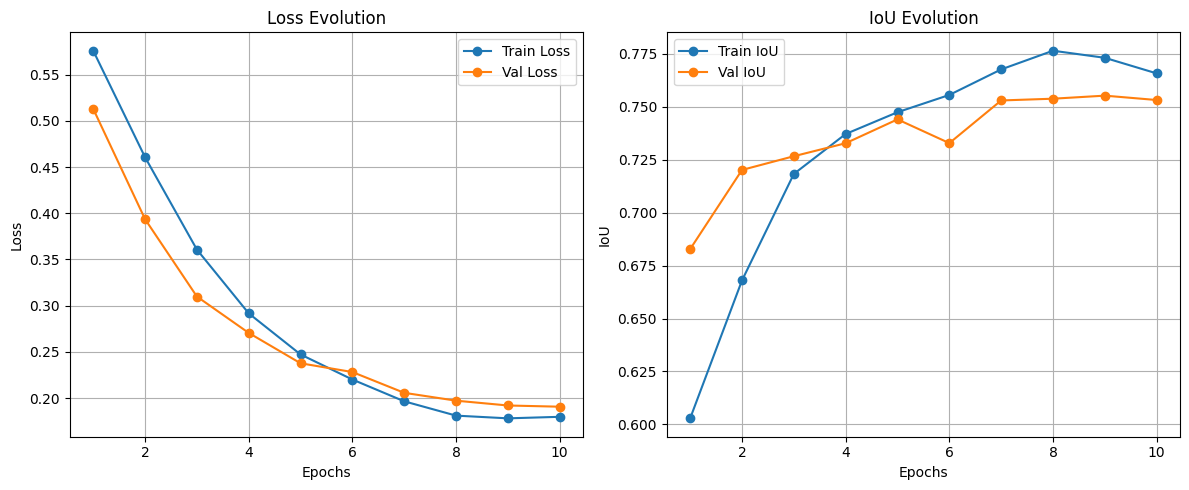

In [25]:
epochs = 10
lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

history=train_model(model, trainloader, valloader, epochs=epochs, lr=lr, device=device)

In [27]:
torch.save(model.state_dict(), "/kaggle/working/vertex_aided_75.pth")

### Prediction Polygons

#### Polygonization function

In [5]:
def preticted_polygone(model, image, model_path):

    model.load_state_dict(torch.load(model_path))
    model.eval()

    image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    
    tsd_m,gauss_den,segmentation_pred = model(image_tensor)
    
    segmentation_pred = (segmentation_pred.squeeze().detach().cpu().numpy()>0.4).astype(np.uint8)
    
    contours, _ = cv2.findContours(segmentation_pred.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    height, width = segmentation_pred.shape
    polygon_map = np.zeros((height, width, 3), dtype=np.uint8)

    for contour in contours:
        approx = cv2.approxPolyDP(contour, 2 ,True)
        cv2.fillPoly(polygon_map, [approx], (0, 255, 0))  

    

    plt.figure(figsize=(10,10))
    
    plt.subplot(1,2,1)
    plt.axis("off")

    plt.imshow(image)
    plt.imshow(cv2.cvtColor(polygon_map, cv2.COLOR_BGR2RGB), alpha=0.3)

    plt.subplot(1,2,2)
    plt.axis("off")

    plt.imshow(image)
    plt.show()

    return tsd_m.squeeze().detach().cpu().numpy(),gauss_den.squeeze().detach().cpu().numpy(),segmentation_pred


#### Test with one image

C:\Users\anskr\AppData\Local\Temp\ipykernel_4864\2553846224.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


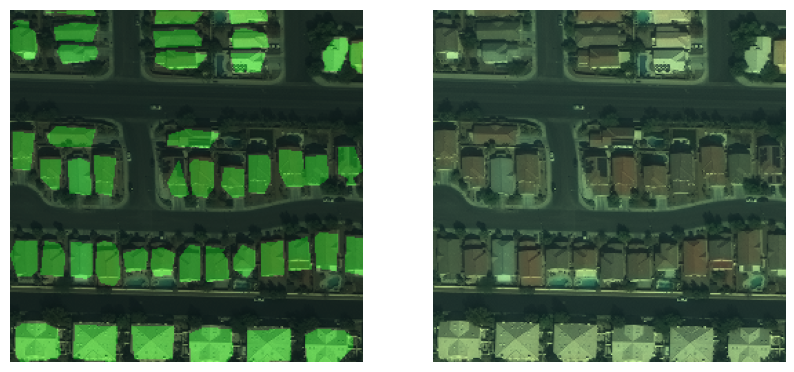

(256, 256) (256, 256) (256, 256)


In [19]:
x,y,z=preticted_polygone(FullModel(),image_test[27],"vertex aided building polygonization.pth")

print(x.shape,y.shape,z.shape)

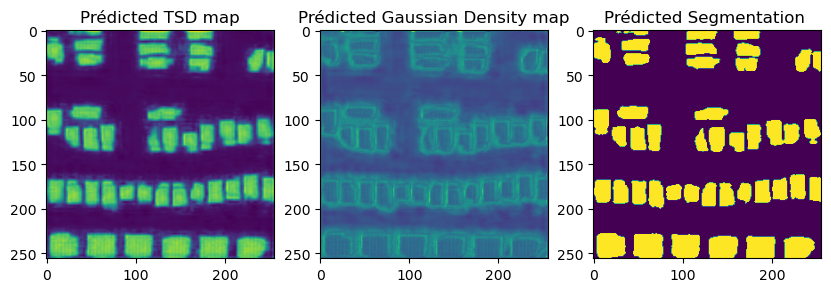

In [20]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.title("Prédicted TSD map")
plt.imshow(x)

plt.subplot(1,3,2)
plt.title("Prédicted Gaussian Density map")
plt.imshow(y)

plt.subplot(1,3,3)
plt.title("Prédicted Segmentation ")
plt.imshow(z)

#### Results visualization

C:\Users\anskr\AppData\Local\Temp\ipykernel_4864\2553846224.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


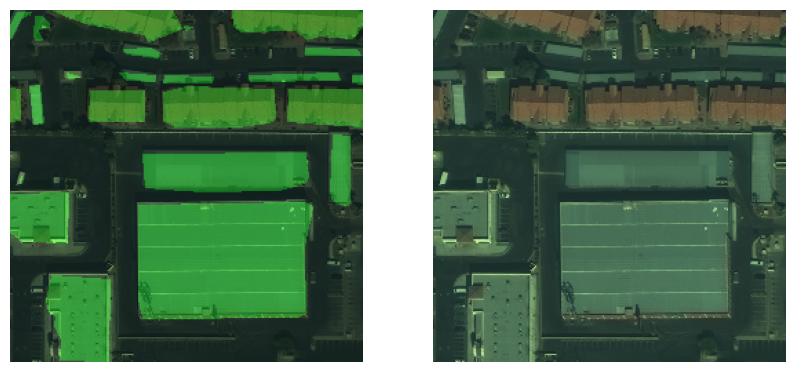

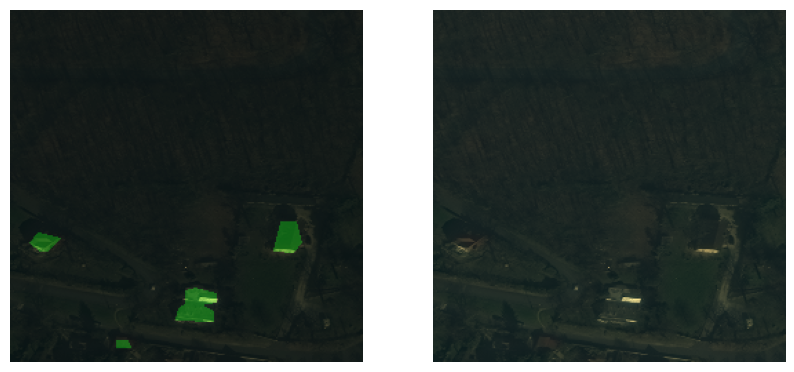

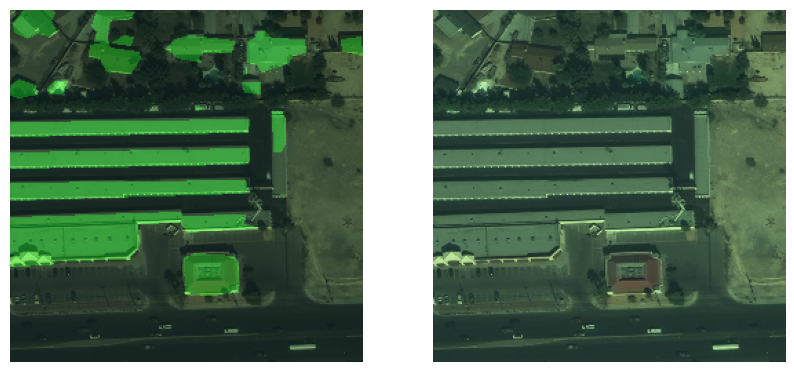

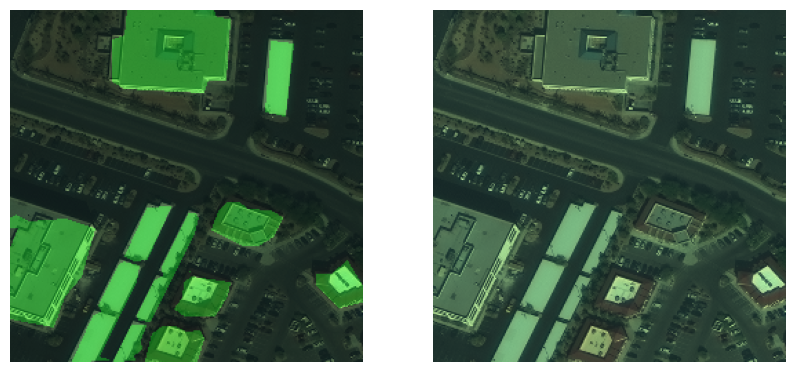

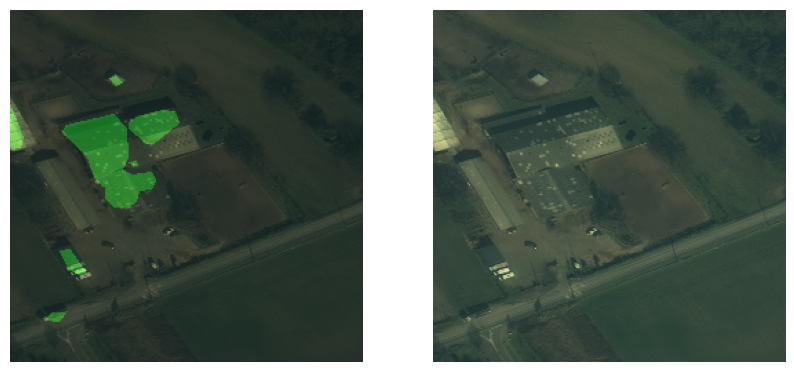

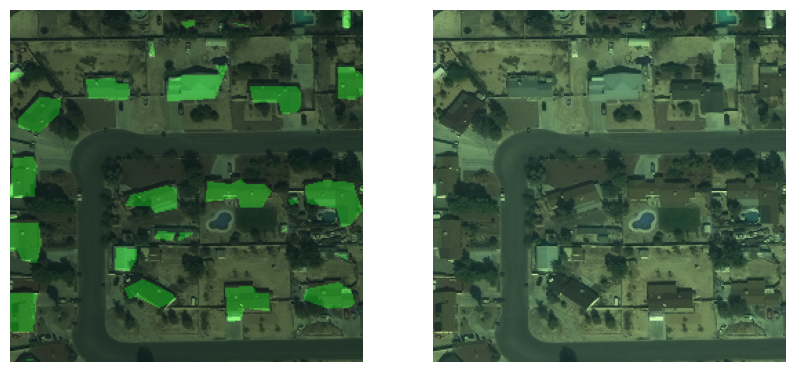

In [21]:
for i in range (2):
    preticted_polygone(FullModel(),image_test[249+i],"vertex aided building polygonization.pth")
    preticted_polygone(FullModel(),image_test[1572+i],"vertex aided building polygonization.pth")
    preticted_polygone(FullModel(),image_test[730+i],"vertex aided building polygonization.pth")

